# Method: Koopman Autoencoders
# Dataset: Lorenz-96, F = 8
# Purpose: Prediction

# 1. Set-up

In [2]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Package
import sys
sys.path.append("../..")

In [3]:
from create_data import load_data, TSData
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time, localtime, strftime

from functools import partial

import jax
from jax import jit, value_and_grad
import jax.numpy as jnp
from jax import random
from jax.example_libraries import optimizers
import jax.example_libraries.stax as stax
from jax.example_libraries.stax import Dense, Relu, Tanh
from jax.nn.initializers import glorot_normal

from scipy.integrate import odeint 

In [4]:
SEED = 42

## Pendulum Model

In [5]:
def pendulum(time_step, num_points, theta_0):
    def model(x, t):
        theta, u = x
        dtheta = u
        du = -9.8 * np.sin(theta)
        dxdt = [dtheta, du]
        return dxdt
    x0 = [theta_0, 0]
    t = np.linspace(0, num_points*time_step, num_points)
    xns = odeint(model, x0, t)
    
    return xns, t

In [6]:
num_pts = 100000 
xns, t = pendulum(0.01, num_pts, 2.8)

In [7]:
output_dim = 64 # Map to higher dimension
P = np.random.normal(size = (output_dim , 2))
Q, R = np.linalg.qr(P)

In [8]:
data_mapped = xns[::5] @ Q.T
data_space = np.arange(0, 64)
data_time = t[::5]
num_pts = data_mapped.shape[0]

In [9]:
train = TSData("Pendulum Train", data = data_mapped[:num_pts//2], space = data_space, time = data_time)
test =  TSData("Pendulum Test", data = data_mapped[num_pts//2:], space = data_space, time = data_time)

In [10]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (10000, 64)
Test size: (10000, 64)


**Create test set**

In [11]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [12]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 200 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [13]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 64)
Test output size: (100, 400, 64)


# 2. Koopman Autoencoder Implementation

In [13]:
def Dense_no_bias(out_dim, W_init = glorot_normal()):
    """Layer constructor function for a dense (fully-connected) layer."""
    def init_fun(rng, input_shape):
        output_shape = input_shape[:-1] + (out_dim,)
        k1, k2 = random.split(rng)
        W = W_init(k1, (input_shape[-1], out_dim))
        return output_shape, W
    def apply_fun(params, inputs, **kwargs):
        W = params
        return jnp.dot(inputs, W)
    return init_fun, apply_fun

In [14]:
def get_params(hidden_state_list, max_lag, lambda_list, seed, batch_size, num_epoch, lr_schedule, 
               early_stopping = EARLY_STOPPING):
    assert len(num_epoch) == len(lr_schedule)
    
    def create_network():
        encoder_init, encoder = stax.serial(
            Dense(p1), Tanh,  
            Dense(p2), Tanh,
            Dense(p3), Tanh,
            Dense(kappa))
        decoder_init, decoder = stax.serial(
            Dense(p3), Tanh,
            Dense(p2), Tanh,
            Dense(p1), Tanh,
            Dense(data_dim))
        forward_init, forward = stax.serial(
            Dense_no_bias(kappa))
        backward_init, backward = stax.serial(
            Dense_no_bias(kappa))

        # initialization
        enc_init_rng, dec_init_rng, forward_init_rng, backward_init_rng = random.split(key, num = 4)

        enc_in_shape = (-1, data_dim)
        dec_in_shape = (-1, kappa)
        forward_in_shape = (-1, kappa)
        backward_in_shape = (-1, kappa)
        _, enc_params = encoder_init(enc_init_rng, enc_in_shape)
        _, dec_params = decoder_init(dec_init_rng, dec_in_shape)
        _, fwd_params = forward_init(forward_init_rng, forward_in_shape)
        _, bwd_params = backward_init(backward_init_rng, backward_in_shape)

        network = (encoder, decoder, forward, backward)
        params = (enc_params, dec_params, fwd_params, bwd_params)
        return network, params
    
    def training(init_params):
        @jit
        def loss(params, batch):
            """
            each batch has dimension Batch_size x (max_lag+1) x dim
            """
            # unpack parameters
            enc_params, dec_params, fwd_params, bwd_params = params
            lambda_id, lambda_fwd, lambda_bwd, lambda_con = lambda_list

            loss_id, loss_fwd, loss_bwd, loss_con = 0, 0, 0, 0

            # AUTOENCODER
            f_start = batch[:,0,:]
            f_target = batch[:,0,:]
            f_encoded = encoder(enc_params, f_start)
            f_predict = decoder(dec_params, f_encoded)
            loss_id = 0.5 * jnp.mean((f_predict - f_target)**2)

            # FORWARD
            f_start = batch[:,0,:]
            f_encoded = encoder(enc_params, f_start)
            for t_steps in range(1, max_lag+ 1):
                # simulate forward
                f_encoded = forward(fwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                f_target = batch[:,t_steps,:]
                loss_fwd += 0.5 * jnp.mean((f_predict - f_target)**2)

            loss_fwd = loss_fwd / max_lag

            # BACKWARD
            f_start = batch[:,-1,:]
            f_encoded = encoder(enc_params, f_start)
            for t_steps in range(1, max_lag + 1):
                f_encoded = backward(bwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                f_target = batch[:,-t_steps-1,:]
                loss_bwd += 0.5 * jnp.mean((f_predict - f_target)**2)

            loss_bwd = loss_bwd / max_lag

            # CONSISTENT
            for k in range(1, kappa + 1):
                C_upper = fwd_params[0][:k, :]
                D_left = bwd_params[0][:, :k]
                C_left = fwd_params[0][:, :k]
                D_upper = bwd_params[0][:k, :]

                I_k = jnp.identity(k)

                loss_con += (jnp.sum((D_upper @ C_left - I_k)**2) + jnp.sum((C_upper @ D_left - I_k)**2)) / (2 * k)

            return lambda_id * loss_id + lambda_fwd * loss_fwd + lambda_bwd * loss_bwd + lambda_con * loss_con
    
        @jit
        def step(i, opt_state, batch):
            params = get_params(opt_state)
            value, g = value_and_grad(loss)(params, batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        def make_forecast(params, batch, L_forecast):
            enc_params, dec_params, fwd_params, bwd_params = params

            preds = []
            f_start = batch[:, 0, :]
            f_encoded = encoder(enc_params, f_start)
            for t in range(L_forecast):
                f_encoded = forward(fwd_params, f_encoded)
                f_predict = decoder(dec_params, f_encoded)
                preds.append(f_predict)
            return np.swapaxes(preds, 0, 1)      
        
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE. Primarily used for validation calculation

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast_test)
            
            #compute MSE
            error = y_pred - y_truth
            mu_loss = np.mean(error**2)
            return mu_loss 
        
        start = time()
        best_params = init_params
        overall_best_mse = 99999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + max_lag))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(max_lag)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(max_lag, max_lag + L_forecast_test)[None,:]).astype(int) 
        x_val = x[t_past_batch_val]
        y_val = y[t_pred_batch_val]
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the data
                T_indices = np.arange(t_size - max_lag - 1)
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch

                    # create 2d array of dimension (batch_size, max_lag + 1) containing all the time indices
                    t_batch = (t_start[:,None] + np.arange(max_lag + 1)[None,:]).astype(int) # transposes data

                    #create batch of dimension (batch_size,  max_lag + 1, data_dim)
                    x_batch = x[t_batch]  

                    params, opt_state, loss_current = step(k, opt_state, x_batch)
                    loss_epoch_train.append(loss_current.item())
                
                mse_train = np.mean(loss_epoch_train)

                # validation
                mse_val = mse(params, x_val, y_val)
                
                if best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch >= 30):
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                if counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
            
        end = time()
        print(f"Total time: {end - start:.2f}")

        return overall_best_params
            
    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    p1, p2, p3, kappa = hidden_state_list # 4 layers (including bottleneck)
        
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    (encoder, decoder, forward, backward), params = create_network()
    final_params = training(params)
    
    return final_params, (encoder, decoder, forward, backward)

In [15]:
def get_test_pred(data_test, params, network):
    start = time()
    
    (encoder, decoder, forward, backward) = network
    enc_params, dec_params, fwd_params, bwd_params = params
    
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data

    preds = []
    f_start = data_test[:, 0, :]
    f_encoded = encoder(enc_params, f_start)
    for t in range(L_forecast_test):
        f_encoded = forward(fwd_params, f_encoded)
        f_predict = decoder(dec_params, f_encoded)
        preds.append(f_predict)

    return np.swapaxes(preds, 0, 1)

# 3. Parameter tuning

There are 3 parameters to tune
- hidden_size - size of the hidden layer
- max_lag - Number of steps calculated for forward and backward dynamics
- loss_weights - [encoder, forward, backward, consistent] loss

## 3.1 hidden_size

**Parameters**
- hidden_size varied
- max_lag = 8
- loss_weights = [1, 1, 0.1, 0.01]

In [16]:
max_lag = 8
loss_weights = [1, 1, .1, .01]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [17]:
res_folder = os.path.join("results", "koopman")

### 3.1.1 hidden_size = [32, 16, 16, 8]

In [30]:
hidden_size = [32, 16, 16, 8]

In [31]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.26 | Train loss = 0.0343267 | Val loss =  0.1669867
Epoch 20: Time taken = 0.25 | Train loss = 0.0122821 | Val loss =  0.1368343
Epoch 30: Time taken = 0.25 | Train loss = 0.0062667 | Val loss =  0.1336581
Epoch 40: Time taken = 0.25 | Train loss = 0.0040145 | Val loss =  0.1388366
Epoch 50: Time taken = 0.27 | Train loss = 0.0026783 | Val loss =  0.1417522
Best Validation MSE: 0.1281605
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.26 | Train loss = 0.0018914 | Val loss =  0.1199515
Epoch 20: Time taken = 0.26 | Train loss = 0.0000813 | Val loss =  0.1168146
Epoch 30: Time taken = 0.25 | Train loss = 0.0000111 | Val loss =  0.1205877
Epoch 40: Time taken = 0.26 | Train loss = 0.0000070 | Val loss =  0.1199240
EARLY STOPPING. Epoch 43: Train loss = 0.0000085 | Val loss =  0.1192416
Best Validation MSE: 0.1139587
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.26 | Train loss = 0.0000201 | Val loss =  0.1174106
Epoch 20: Time taken =

In [62]:
mean_pred = get_test_pred(X_test, params, network)

In [66]:
class PointExperimentResult():
    """
    Valid for point estimate (only performing prediction of next point)
    """
    def __init__(self, test_error, details, params = None):
        self.params = params
        self.error = test_error    
        self.details = details
        self.rmse = np.sqrt(np.mean(self.error**2, axis=2))
        self.quantile_list = None
        
    def get_rmse(self):
        return self.rmse
    
    def plot_rmse(self, error_thresh = 1, dt = 0.01):
        if self.quantile_list is None:
            self.quantile_list = np.quantile(self.rmse, q = [0.25,0.50,0.75], axis=0)
            
        L_forecast = self.error.shape[1]

        plt.fill_between(x = np.arange(L_forecast) * dt,
                         y1 = self.quantile_list[0,:],
                         y2 = self.quantile_list[2,:],
                         color="red",
                         alpha=0.5)
        plt.plot(np.arange(L_forecast) * dt, self.quantile_list[1,:], "b-", lw = 3)
        plt.grid(True)
        plt.axhline(error_thresh, c = "r", ls = "--")
        plt.ylabel("NRMSE")
        plt.yscale("log")
        plt.xlabel("Forecast Horizon (seconds)")                
        plt.show()
        
        first_max = np.argmax(self.quantile_list[1, :] > error_thresh)
        print(f"It takes around t = {first_max * dt:.2f} for mean error to exceed {error_thresh}")

    def get_loss(self, time, dt = 0.01):
        if self.quantile_list is None:
            raise Exception("Quantiles not generated. Run plot_rmse first")
        median = self.quantile_list[1, :]
        if type(time) == float or type(time) == int:
            print(f"Median NRMSE at t = {time}: {median[int(time / dt)]:.3f}")
        else:
            for t in time:
                print(f"Median NRMSE at t = {t}: {median[int(t / dt)]:.3f}")

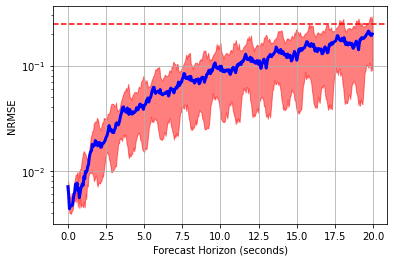

It takes around t = 0.00 for mean error to exceed 0.25

Median NRMSE at t = 0.5: 0.007
Median NRMSE at t = 1: 0.007
Median NRMSE at t = 2: 0.018
Median NRMSE at t = 3: 0.023


In [67]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = .25, dt = .05)
print()
res_single.get_loss([.5, 1, 2, 3], dt = .05)

In [23]:
idx = 0

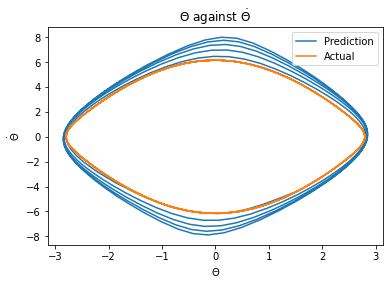

In [69]:
plt.plot((mean_pred @ Q)[idx][:, 0], (mean_pred @ Q)[idx][:, 1], label = "Prediction")
plt.plot((y_test @ Q)[idx][:, 0], (y_test @ Q)[idx][:, 1], label = "Actual")
plt.title("$\Theta$ against $\dot{\Theta}$")
plt.xlabel("$\Theta$")
plt.ylabel("$\dot{\Theta}$")
plt.legend(loc = 1)
plt.savefig("Figure3-9_Koopman_Pendulum.png", facecolor = "white", bbox_inches = "tight")
plt.show()

# 3. Parameter tuning

There are 3 parameters to tune
- hidden_size - size of the hidden layer
- max_lag - Number of steps calculated for forward and backward dynamics
- loss_weights - [encoder, forward, backward, consistent] loss

## 3.1 hidden_size

**Parameters**
- hidden_size varied
- max_lag = 8
- loss_weights = [1, 1, 0.1, 0.01]

In [16]:
max_lag = 8
loss_weights = [1, 1, .1, .01]

batch_size = 128
epoch_list = [50, 50, 50]
lr_list = [1e-3, 1e-4, 1e-5]

In [17]:
res_folder = os.path.join("results", "koopman")

### 3.1.1 hidden_size = [32, 16, 16, 8]

In [18]:
hidden_size = [32, 16, 16, 8]

In [19]:
params, network = get_params(hidden_size, max_lag, loss_weights, SEED, batch_size, epoch_list, lr_list)

Backpropogation start

Epoch 10: Time taken = 0.44 | Train loss = 0.0328342 | Val loss =  0.4440373
Epoch 20: Time taken = 0.45 | Train loss = 0.0116762 | Val loss =  0.2268128
Epoch 30: Time taken = 0.46 | Train loss = 0.0048229 | Val loss =  0.2962941
Epoch 40: Time taken = 0.47 | Train loss = 0.0023919 | Val loss =  0.3227347
Epoch 50: Time taken = 0.46 | Train loss = 0.0011718 | Val loss =  0.2942206
Best Validation MSE: 0.2263330
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.62 | Train loss = 0.0016314 | Val loss =  0.2760764
Epoch 20: Time taken = 0.51 | Train loss = 0.0002567 | Val loss =  0.2209497
Epoch 30: Time taken = 0.47 | Train loss = 0.0000262 | Val loss =  0.0623064
Epoch 40: Time taken = 0.47 | Train loss = 0.0000108 | Val loss =  0.1279143
Epoch 50: Time taken = 0.47 | Train loss = 0.0000090 | Val loss =  0.1908666
Best Validation MSE: 0.0418775
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.48 | Train loss = 0.0000166 | Val loss =  0.0751928
Epoch 20: Time tak

In [20]:
mean_pred = get_test_pred(X_test, params, network)

In [44]:
class PointExperimentResult():
    """
    Valid for point estimate (only performing prediction of next point)
    """
    def __init__(self, test_error, details, params = None):
        self.params = params
        self.error = test_error    
        self.details = details
        self.rmse = np.sqrt(np.mean(self.error**2, axis=2))
        self.quantile_list = None
        
    def get_rmse(self):
        return self.rmse
    
    def plot_rmse(self, error_thresh = 1, dt = 0.01):
        if self.quantile_list is None:
            self.quantile_list = np.quantile(self.rmse, q = [0.25,0.50,0.75], axis=0)
            
        L_forecast = self.error.shape[1]

        plt.fill_between(x = np.arange(L_forecast) * dt,
                         y1 = self.quantile_list[0,:],
                         y2 = self.quantile_list[2,:],
                         color="red",
                         alpha=0.5)
        plt.plot(np.arange(L_forecast) * dt, self.quantile_list[1,:], "b-", lw = 3)
        plt.grid(True)
        plt.axhline(error_thresh, c = "r", ls = "--")
        plt.ylabel("NRMSE")
        plt.xlabel("Forecast Horizon (seconds)")                
        # plt.savefig("Koopman_Pendulum_PH.png", facecolor = "white", bbox_inches = "tight")
        plt.show()
        
        first_max = np.argmax(self.quantile_list[1, :] > error_thresh)
        print(f"It takes around t = {first_max * dt:.2f} for mean error to exceed {error_thresh}")

    def get_loss(self, time, dt = 0.01):
        if self.quantile_list is None:
            raise Exception("Quantiles not generated. Run plot_rmse first")
        median = self.quantile_list[1, :]
        if type(time) == float or type(time) == int:
            print(f"Median NRMSE at t = {time}: {median[int(time / dt)]:.3f}")
        else:
            for t in time:
                print(f"Median NRMSE at t = {t}: {median[int(t / dt)]:.3f}")

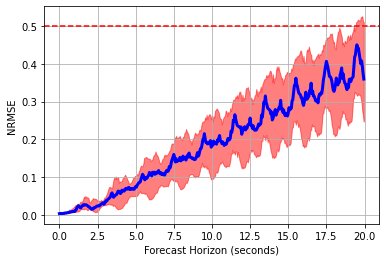

It takes around t = 0.00 for mean error to exceed 0.5

Median NRMSE at t = 1: 0.009
Median NRMSE at t = 2: 0.019
Median NRMSE at t = 5: 0.076
Median NRMSE at t = 15: 0.270


In [45]:
desc_name = "koopman_autoencoder"
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = .5, dt = .05)
print()
res_single.get_loss([1, 2, 5, 15], dt = .05)

In [34]:
idx = 0

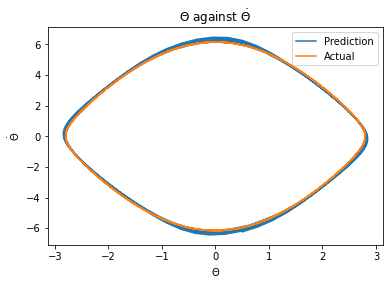

In [43]:
plt.plot((mean_pred @ Q)[idx][:, 0], (mean_pred @ Q)[idx][:, 1], label = "Prediction")
plt.plot((y_test @ Q)[idx][:, 0], (y_test @ Q)[idx][:, 1], label = "Actual")
plt.title("$\Theta$ against $\dot{\Theta}$")
plt.xlabel("$\Theta$")
plt.ylabel("$\dot{\Theta}$")
plt.legend(loc = 1)
plt.savefig("Figure3-9_Koopman_Pendulum.png", facecolor = "white", bbox_inches = "tight")
plt.show()